# Homework

In [101]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [44]:
df_full = pd.read_csv("bank-full.csv", sep=";")
features = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
df = df_full[features + ['y']].copy()
df['y'] = (df['y'] == 'yes').astype(int)

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
y_full_train = df_full_train.y
y_test = df_test.y
y_train = df_train.y
y_val = df_val.y


# Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* balance
* day
* duration
* previous


In [45]:
numerical = list(df.dtypes[df.dtypes != 'object'].keys())

for column in numerical:
    score = roc_auc_score(df_train.y, df_train[column])
    if score < 0.5:
        score = roc_auc_score(df_train.y, -df_train[column])
    print(f"{column}:", score )


age: 0.512185717527344
balance: 0.5888313805382317
day: 0.525957882383908
duration: 0.8147002759670778
campaign: 0.5714543015682159
pdays: 0.5901276247352144
previous: 0.5985653242764153
y: 1.0


> A/ `duration`

# Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.69
* 0.79
* 0.89
* 0.99

In [63]:
# Train
dicts = df_train[features].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict
dicts = df_val[features].to_dict(orient='records')
X_val = dv.fit_transform(dicts)
y_pred = model.predict_proba(X_val)[:, 1]

auc = round(roc_auc_score(y_val, y_pred), 3)
auc




np.float64(0.9)

> A/ `0.89`

# Question 3: Precision and Recall
Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

0.27


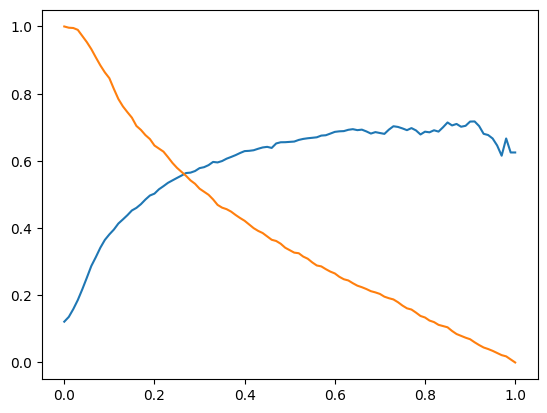

In [94]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

thresholds = []
precissions = []
recalls = []

for threshold in np.linspace(0, 1, 100):
    threshold = round(threshold, 2)
    thresholds.append(threshold)
    predict_positive = (y_pred >= threshold)
    predict_negative = (y_pred < threshold)
    # True positives
    tp = (predict_positive & actual_positive).sum()
    # False positives
    fp = (predict_positive & actual_negative).sum()
    # False negatives
    fn = (predict_negative & actual_positive).sum()
    # Precission
    if tp + fp > 0:
        precission = tp / (tp + fp)
    
    if tp + fn > 0:
        recall = tp / (tp + fn)

    precissions.append(precission)
    recalls.append(recall)

    if round(precission, 2) == round(recall, 2):
        print(threshold)

plt.plot(thresholds, precissions, label='Precission')
plt.plot(thresholds, recalls, label = "Recall")

> A/`0.265`

# Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

In [100]:
f1_scores = []
for i in range(len(thresholds)):
    f1 = 2 * ((precissions[i] * recalls[i]) / (precissions[i] + recalls[i]))
    f1_scores.append(f1)

thresholds[f1_scores.index(max(f1_scores))]



np.float64(0.22)

A/`0.22`

# Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

* 0.0001
* 0.006
* 0.06
* 0.26

In [103]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y
    y_val = df_val.y

    # Train
    dicts = df_train[features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # Predict
    dicts = df_val[features].to_dict(orient='records')
    X_val = dv.fit_transform(dicts)
    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


> A/`0.006`

# Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.000001, 0.001, 1]
* Initialize KFold with the same parameters as previously
* Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

* 0.000001
* 0.001
* 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [105]:
for C in [0.000001, 0.001, 1]:
    scores = []

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        # Train
        dicts = df_train[features].to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(dicts)
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        
        # Predict
        dicts = df_val[features].to_dict(orient='records')
        X_val = dv.fit_transform(dicts)
        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('%f: %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

0.000001: 0.701 +- 0.009
0.001000: 0.861 +- 0.007
1.000000: 0.906 +- 0.006


> A/`1`